# Tutorial on PnP-LADMM

#### Imports

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from torchvision.transforms import GaussianBlur


import torch
from torchmetrics.image import TotalVariation
from torchmetrics.functional.image import image_gradients

from metricas import *
from degradacion import *

#### Data-loading

In [2]:
#cargo las imagenes
img_file_name = random.choice(os.listdir("./imagenes"))
img = imread(os.path.join("./imagenes", img_file_name), as_gray=True)
x_real = torch.tensor(img)

In [3]:
x_real = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))

In [4]:
sigma_blurr = 10
filter_size = 7

ker = GaussianBlur(filter_size, sigma_blurr)

def T(x):

    x_op = x.expand(1, x.shape[0], x.shape[1])

    return ker.forward(x_op)[0,:,:]

In [5]:
def T_degradacion(x):

    return forward(x)

def normalize(x):

    return (x - x.min())/(x.max() - x.min())

In [6]:
y = T(x_real)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Imagen real:



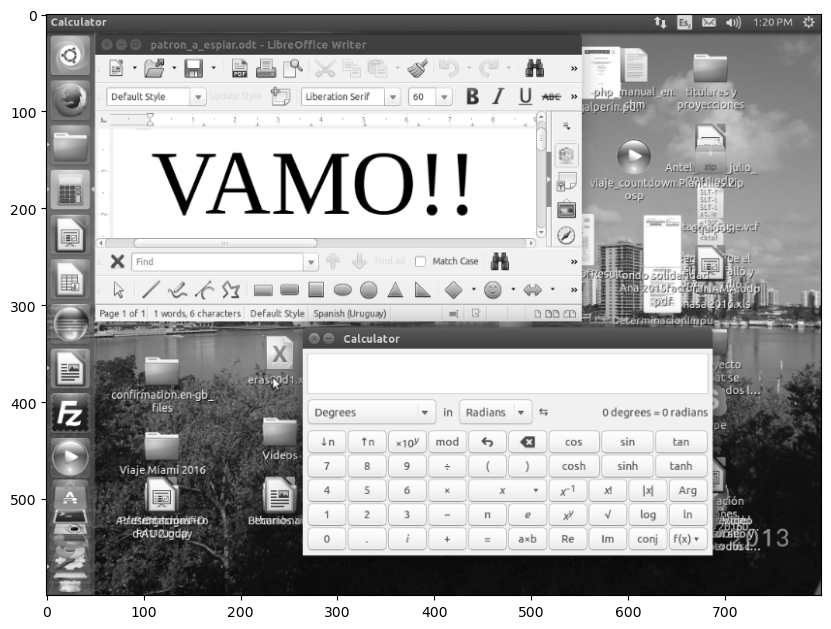

Imagen degradada:



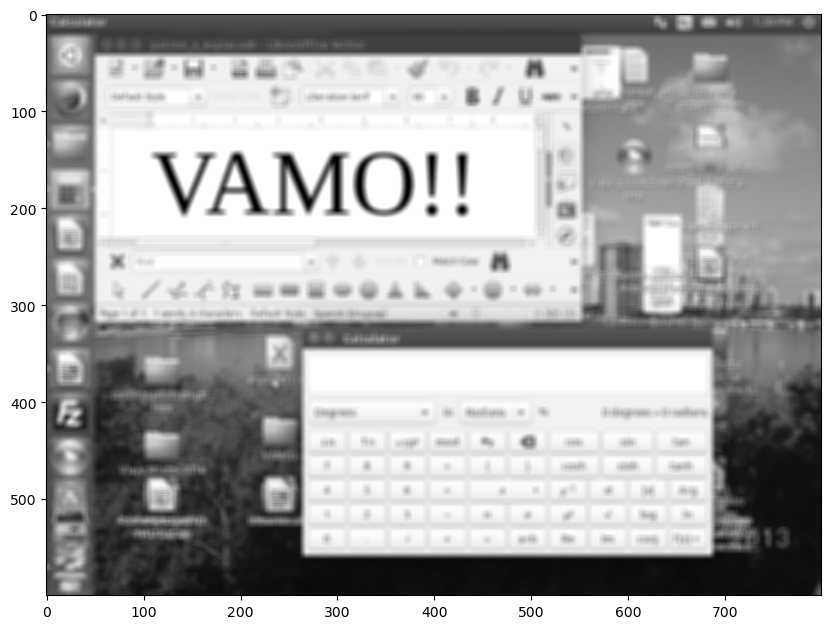

In [7]:
print("Imagen real:\n")

plt.figure(figsize=(10,8))
plt.imshow(x_real, cmap="gray")
plt.show()

print("Imagen degradada:\n")

plt.figure(figsize=(10,8))
plt.imshow(y, cmap="gray")
plt.show()

#print("Imagen degradada invertida:\n")

#plt.figure(figsize=(10,8))
#plt.imshow(1-y, cmap="gray")
#plt.show()

#### Creation of the model

In [8]:
lam = 5
sigma_energia = 0.1

tv = TotalVariation()

def f_energia(x):

    return (1/(2*sigma_energia**2)) * torch.norm(y - T_degradacion(x))**2

def TV(x):

    x = x.unsqueeze(0).unsqueeze(0)
    
    return lam * tv(x)

def L1(x, eps=1e-5):

    resu = torch.sum( torch.square(x) )

    return lam * (resu + eps)**(1/2)

def L2(x):

    return lam * torch.norm(x, p=2)**2

In [9]:
def grad_L2(x):

    return 2*lam*x

def grad_L1(x, eps=1e-5):

    return (lam / L1(x, eps)) * x  

def grad_TV(x, eps = 0.1):
    
    x = x.unsqueeze(0).unsqueeze(0)

    grad_x = image_gradients(x)

    norma_gradx = torch.norm(grad_x[0][0,0,:,:])
    norma_grady = torch.norm(grad_x[1][0,0,:,:])

    denominador = torch.sqrt(eps**2 + norma_gradx**2 + norma_grady**2).item()

    cociente_x = grad_x[0] / denominador
    cociente_y = grad_x[1] / denominador
    
    derivada_cociente_x = image_gradients(cociente_x)
    derivada_cociente_y = image_gradients(cociente_y)

    gradiente_tv = derivada_cociente_x[0][0,0,:,:] + derivada_cociente_y[1][0,0,:,:]

    return lam * gradiente_tv

In [10]:
f = f_energia
h = TV

grad_h = grad_TV

cte_h_lipz = 30

In [11]:
def minimizeViaTorch(funcion_objetivo, x0, lr=0.1, max_iter=10_000, eps=1e-6):

    params = x0
    params.requires_grad_()
    optimizer = torch.optim.Adam([params], lr=lr)

    diff = torch.inf

    k = 0

    while (k < max_iter) and (diff > eps):

        print(f"k: {k}, diff: {diff}", end="\r", flush=True)

        params_ant = params.detach().clone()

        optimizer.zero_grad()
        loss = funcion_objetivo(params)
        loss.backward(retain_graph=True)
        optimizer.step()

        params_sig = params.detach().clone()

        diff = torch.norm(params_sig - params_ant)

        k += 1

    print("\n\n")

    return params.detach().clone()

In [12]:
def PROX_function(x, v, param, func):

    return func(x) + (1/(2*param)) * torch.norm(x - v)**2

#### Run model

ATENCIÓN: La siguiente celda puede llegar a demorar más de media hora dependiendo del hardware

In [13]:
eps = 1e-4
max_iter = 50

Lz = round(cte_h_lipz + cte_h_lipz**2 + 3) + 1
beta = max( cte_h_lipz + Lz + 2 , 3*(Lz**2 + cte_h_lipz**2)/((Lz + cte_h_lipz**2)/2) , 3*Lz**2) + 1
Lx = round(beta + 6*cte_h_lipz**2 + 1) + 1

diff_x = torch.inf
diff_z = torch.inf
diff_gamma = torch.inf

#x = torch.zeros_like(x_real)
#z = torch.ones_like(x_real)
x = y.clone()
z = x.clone()

Nz = z.shape[0]

gamma = torch.ones(x.shape)

mat_inv = torch.from_numpy( np.linalg.inv(Lz + beta*np.identity(Nz)))

nIter = 1
while (nIter <= max_iter) and (max(diff_x, diff_z, diff_gamma) > eps):

    print(f"Iteracion: {nIter}/{max_iter}", end="\r", flush=True)

    print(f"\ndiff_x: {diff_x}")
    print(f"diff_z: {diff_z}")
    print(f"diff_gamma: {diff_gamma}\n")

    if diff_x > 0:
        
        def actualizacion_x(x_param):

            return f(x_param) + torch.sum(gamma * x_param) + (Lx/2) * torch.norm(x_param - x)**2 + torch.sum((x_param - x) * (beta*(x - z)))
    
        # Actualizacion de x
        x_sig = minimizeViaTorch(actualizacion_x, x0=x, lr=1e-4, max_iter=1e6, eps=1e-5)

    # Actualizacion de z
    z_sig = mat_inv @ (Lz*z - grad_h(z) + gamma + beta*x_sig)
    
    # Actualizacion de gamma
    gamma_sig = gamma + beta*(x_sig - z_sig)

    # Recalculo diferencias entre actualizaciones
    diff_x = torch.norm(x_sig - x)
    diff_z = torch.norm(z_sig - z)
    diff_gamma = torch.norm(gamma_sig - gamma)

    # Asigno la actualizacion
    gamma = gamma_sig.clone()
    x = x_sig.clone()
    z = z_sig.clone()

    nIter += 1

print("\nTermino!")

Iteracion: 1/50
diff_x: inf
diff_z: inf
diff_gamma: inf



KeyboardInterrupt: 

In [15]:
x = normalize(x)
z = normalize(z)

In [ ]:
x = torch.where(x >= 0, x, 0)
x = torch.where(x <= 1, x, 1)

z = torch.where(z >= 0, z, 0)
z = torch.where(z <= 1, z, 1)

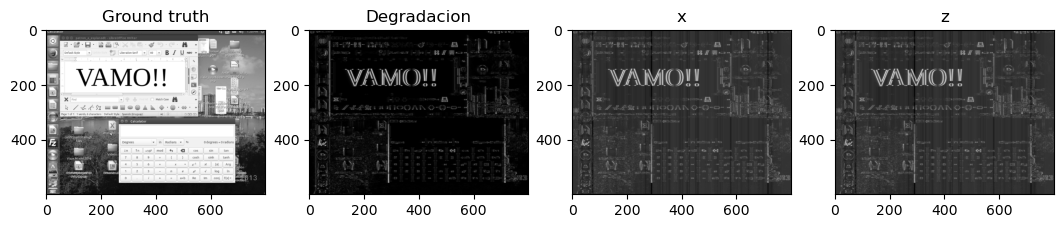

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(13,8))

axs[0].imshow(x_real, cmap="gray")
axs[0].set_title("Ground truth")

axs[1].imshow(y.detach(), cmap="gray")
axs[1].set_title("Degradacion")

axs[2].imshow(x.detach(), cmap="gray")
axs[2].set_title("x")

axs[3].imshow(z.detach(), cmap="gray")
axs[3].set_title("z")

plt.show()


#fig, axs = plt.subplots(1, 4, figsize=(13,8))

#axs[0].imshow(x_real, cmap="gray")
#axs[0].set_title("Ground truth")

#axs[1].imshow(1-y.detach(), cmap="gray")
#axs[1].set_title("Degradacion")

#axs[2].imshow(1-x.detach(), cmap="gray")
#axs[2].set_title("x")

#axs[3].imshow(1-z.detach(), cmap="gray")
#axs[3].set_title("z")

#plt.show()

In [ ]:
print("Ground truth:")
plt.figure(figsize=(10,8))
plt.imshow(x_real, cmap = 'gray')
plt.show()

print("Degradacion:")
plt.figure(figsize=(10,8))
plt.imshow(y.detach(), cmap = 'gray')
plt.show()

print("x:")
plt.figure(figsize=(10,8))
plt.imshow(x.detach(), cmap = 'gray')
plt.show()

print("z:")
plt.figure(figsize=(10,8))
plt.imshow(z.detach(), cmap = 'gray')
plt.show()

In [ ]:
print("x VS x_real")
print("="*30)

print(f"PSNR: {PSNR(x, x_real):0.4f} (PSNR ref.: {PSNR(x_real, x_real):0.4f})")
print(f"SSIM: {SSIM(x, x_real):0.4f}")
print(f"MS-SSIM: {MS_SSIM(x, x_real):0.4f}")
print(f"IW-SSIM: {IW_SSIM(x, x_real):0.4f}")

print()

print("y VS x_real")
print("="*30)

print(f"PSNR: {PSNR(y, x_real):0.4f} (PSNR ref.: {PSNR(x_real, x_real):0.4f})")
print(f"SSIM: {SSIM(y, x_real):0.4f}")
print(f"MS-SSIM: {MS_SSIM(y, x_real):0.4f}")
print(f"IW-SSIM: {IW_SSIM(y, x_real):0.4f}")

In [ ]:
imsave(f"./imagenes_restauradas/{img_file_name}", x.detach())

#### Grid-search

In [ ]:
import pandas as pd

In [ ]:
lams = [0, 0.5, 2, 5]
sigmas_energia = [0.01, 0.1, 1, 10]

df = pd.DataFrame(index=range(len(lams)*len(sigmas_energia)), columns=["lambda", "sigma", "PSNR", "SSIM", "MS-SSIM", "IW-SSIM"])

i = 0
for lam in lams:
    for sigma_energia in sigmas_energia:

        # Defino funciones con variables globales
        tv = TotalVariation()

        def f_energia(x):

            return (1/(2*sigma_energia**2)) * torch.norm(y - T_degradacion(x))**2

        def TV(x):

            x = x.unsqueeze(0).unsqueeze(0)

            return lam * tv(x)

        def L1(x):

            return lam * torch.norm(x, p=1)

        def L2(x):

            return lam * torch.norm(x, p=2)**2
        
        def grad_L2(x):

            return 2*lam*x

        def grad_L1(x):

            return lam * np.sign(x)

        def grad_TV(x, eps = 0.1):
            
            x = x.unsqueeze(0).unsqueeze(0)

            grad_x = image_gradients(x)

            norma_gradx = torch.norm(grad_x[0][0,0,:,:])
            norma_grady = torch.norm(grad_x[1][0,0,:,:])

            denominador = torch.sqrt(eps**2 + norma_gradx**2 + norma_grady**2).item()

            cociente_x = grad_x[0] / denominador
            cociente_y = grad_x[1] / denominador
            
            derivada_cociente_x = image_gradients(cociente_x)
            derivada_cociente_y = image_gradients(cociente_y)

            gradiente_tv = derivada_cociente_x[0][0,0,:,:] + derivada_cociente_y[1][0,0,:,:]

            return lam * gradiente_tv
        
        f = f_energia
        h = L2

        grad_h = grad_L2

        cte_h_lipz = 2*lam


        eps = 1e-6
        max_iter = 2_000

        Lz = round(cte_h_lipz + cte_h_lipz**2 + 3) + 1
        beta = max( cte_h_lipz + Lz + 2 , 3*(Lz**2 + cte_h_lipz**2)/((Lz + cte_h_lipz**2)/2) , 3*Lz**2) + 1
        Lx = round(beta + 6*cte_h_lipz**2 + 1) + 1

        diff_x = torch.inf
        diff_z = torch.inf
        diff_gamma = torch.inf

        #x = torch.zeros_like(x_real)
        #z = torch.ones_like(x_real)
        x = y.clone()
        z = x

        Nz = z.shape[0]

        gamma = torch.ones(x.shape)

        mat_inv = torch.from_numpy( np.linalg.inv(Lz + beta*np.identity(Nz)))


        nIter = 1

        while (nIter <= max_iter) and (max(diff_x, diff_z, diff_gamma) > eps):

            print(f"Iteracion: {nIter}/{max_iter}", end="\r", flush=True)
            
            if diff_x > 0:
                
                def actualizacion_x(x_param):

                    return f(x_param) + torch.sum(gamma * x_param) + (Lx/2) * torch.norm(x_param - x)**2 + torch.sum((x_param - x) * (beta*(x - z)))
            
                # Actualizacion de x
                x_sig = minimizeViaTorch(actualizacion_x, x0=x, lr=0.1, max_iter=1_000_000)

            # Actualizacion de z
            z_sig = mat_inv @ (Lz*z - grad_h(z) + gamma + beta*x_sig)
            
            # Actualizacion de gamma
            gamma_sig = gamma + beta*(x_sig - z_sig)

            # Recalculo diferencias entre actualizaciones
            diff_x = torch.norm(x_sig - x)
            diff_z = torch.norm(z_sig - z)
            diff_gamma = torch.norm(gamma_sig - gamma)

            # Asigno la actualizacion
            gamma = gamma_sig
            x = x_sig
            z = z_sig

            nIter += 1

        
        x = torch.where(x >= 0, x, 0)
        x = torch.where(x <= 1, x, 1)

        z = torch.where(z >= 0, z, 0)
        z = torch.where(z <= 1, z, 1)

        psnr_x = PSNR(x, x_real)
        ssim_x = SSIM(x, x_real)
        ms_ssim_x = MS_SSIM(x, x_real)
        iw_ssim_x = IW_SSIM(x, x_real)

        df.iloc[i,:] = [lam, sigma_energia, psnr_x, ssim_x, ms_ssim_x, iw_ssim_x]

        i += 1

In [ ]:
df.head(50)

In [ ]:
plt.figure(figsize=(12,8))

metrica = "IW-SSIM"

for i, sigma_energia in enumerate(sigmas_energia):
    
    df_aux = df.loc[ df.iloc[:,1]==sigma_energia ]
    plt.plot(df_aux.iloc[:,0], df_aux.loc[:,metrica], label=f"$\sigma$: {sigma_energia}")

plt.xlabel(f"$\lambda$")
plt.ylabel(metrica)
plt.grid()
plt.legend()
plt.title(f"Grid-search: {metrica}")
plt.show()